# ECOD pyOD

In [1]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=dce80a2271f60aca43a37c1fdabe53853dc763601d082354f36d3f1f7f7004ee
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [2]:
cd ./drive/MyDrive/InControl/

/content/drive/MyDrive/InControl


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import os
import numpy as np

# cnx = sqlite3.connect('YUGRES_all.sqlite')
# print(cnx.cursor)
# test_df = pd.read_sql_query("SELECT * FROM 'data'", cnx, parse_dates=True,index_col = 'timestamp')
test_df = pd.read_csv('data.csv', index_col = 'timestamp', parse_dates=True, squeeze=True)
test_df = test_df[test_df['20MBY10CE901_XQ01']>195]
# time_ = pd.to_datetime(test_df['timestamp'])
# # Создаем список названий столбцов, которые начинаются с "20"
selected_columns = [col for col in test_df.columns if col.startswith("20")]
# # Создаем новый DataFrame, содержащий только выбранные столбцы
df_selected_test = test_df[selected_columns]
# df_selected_test.index = time_

<ipython-input-3-4e1f92c1e301>:11: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  test_df = pd.read_csv('data.csv', index_col = 'timestamp', parse_dates=True, squeeze=True)


In [4]:
df_selected_test.fillna(method='ffill', inplace=True)

# Масштабирование данных (Min-Max Scaling)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_selected_test)

<ipython-input-4-6f254272bed2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_test.fillna(method='ffill', inplace=True)


In [5]:
from pyod.models.ecod import ECOD
clf_name = 'ECOD'
clf = ECOD()
clf.fit(scaled_data)

# get outlier scores
y_train_scores = clf.decision_scores_ # raw outlier scores on the train data
# y_test_scores = clf.decision_function(df)  # predict raw outlier scores on test
y_train_pred = clf.labels_
print(y_train_scores)
print(y_train_pred)


[297.74874756 299.51691476 293.37324447 ... 305.39018912 303.43078252
 303.26551771]
[0 0 0 ... 0 0 0]


In [6]:
import scipy
def scaler_loss(target_value, scaler_name, range_loss = 100):
            if scaler_name == 'cdf':
                hist = np.histogram(target_value, bins=range_loss)
                # logger.debug(target_value)
                scaler_loss = scipy.stats.rv_histogram(hist)
                # logger.debug(hist)
                target_value = scaler_loss.cdf(target_value)*range_loss
                scaler_loss = hist
            elif scaler_name == 'minmax':
                scaler_loss = MinMaxScaler(feature_range=(0, range_loss))
                loss_2d = np.reshape(target_value, (-1,1))
                scaler_loss.fit(loss_2d)
                target_value = scaler_loss.transform(loss_2d)
            return target_value, scaler_loss

In [7]:
loss = scaler_loss(y_train_scores,'cdf')

In [8]:
df_loss = pd.DataFrame()
df_loss['loss'] = y_train_scores
target_value, scaler_loss = scaler_loss(df_loss['loss'],'cdf')
print(target_value)



[36.54543732 37.39496831 34.4373804  ... 39.8588725  39.03687955
 38.96754912]


In [9]:
df_target = pd.DataFrame()
df_target['target_value'] = target_value
df_target.index = df_selected_test.index
print(df_target)
df_target.to_csv('pyOD_ECOD.csv')

                     target_value
timestamp                        
2017-01-01 00:00:00     36.545437
2017-01-01 00:05:00     37.394968
2017-01-01 00:10:00     34.437380
2017-01-01 00:15:00     35.028509
2017-01-01 00:20:00     36.737992
...                           ...
2019-07-23 20:40:00     39.605127
2019-07-23 20:45:00     39.758460
2019-07-23 20:50:00     39.858873
2019-07-23 20:55:00     39.036880
2019-07-23 21:00:00     38.967549

[204186 rows x 1 columns]


In [10]:
df = pd.read_csv('pyOD_ECOD.csv')

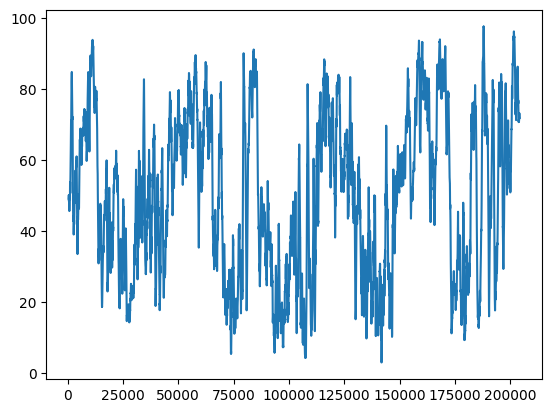

In [11]:
window_size = 512
df['target_mean'] = df['target_value'].rolling(window=window_size).mean()
plt.plot(df['target_mean'])

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [13]:
import pandas as pd

data_to_remove = {
    'Начало': ['2017-01-13 16:05:00', '2017-01-24 13:35:00', '2017-12-22 00:00:00',
               '2017-12-22 00:00:00', '2017-03-05 00:00:00', '2017-03-03 00:00:00',
               '2017-12-22 18:10:00', '2019-05-25 01:10:00', '2017-07-06 00:00:00',
               '2019-05-26 00:00:00', '2017-03-03 00:00:00'],
    'Конец': ['2017-01-21 08:50:00', '2017-02-06 05:00:00', '2018-02-19 00:00:00',
             '2017-12-22 23:55:00', '2017-03-05 23:55:00', '2017-03-03 23:55:00',
             '2018-02-20 20:55:00', '2019-05-28 14:45:00', '2017-07-06 23:55:00',
             '2019-05-26 23:55:00', '2017-03-03 23:55:00']
}

# Преобразуем даты в формат Timestamp
date_tuples = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end in zip(data_to_remove['Начало'], data_to_remove['Конец'])]

print(date_tuples)

[(Timestamp('2017-01-13 16:05:00'), Timestamp('2017-01-21 08:50:00')), (Timestamp('2017-01-24 13:35:00'), Timestamp('2017-02-06 05:00:00')), (Timestamp('2017-12-22 00:00:00'), Timestamp('2018-02-19 00:00:00')), (Timestamp('2017-12-22 00:00:00'), Timestamp('2017-12-22 23:55:00')), (Timestamp('2017-03-05 00:00:00'), Timestamp('2017-03-05 23:55:00')), (Timestamp('2017-03-03 00:00:00'), Timestamp('2017-03-03 23:55:00')), (Timestamp('2017-12-22 18:10:00'), Timestamp('2018-02-20 20:55:00')), (Timestamp('2019-05-25 01:10:00'), Timestamp('2019-05-28 14:45:00')), (Timestamp('2017-07-06 00:00:00'), Timestamp('2017-07-06 23:55:00')), (Timestamp('2019-05-26 00:00:00'), Timestamp('2019-05-26 23:55:00')), (Timestamp('2017-03-03 00:00:00'), Timestamp('2017-03-03 23:55:00'))]


In [14]:
import numpy as np
import pandas as pd

# Замените 'df' на вашу собственную переменную DataFrame
# и 'timestamp' на имя столбца с временными метками,
# 'value' на имя столбца со значениями

# Рассчитываем порог
short_threshold = 85

# Создаем список, чтобы хранить интервалы
intervals = []

# Инициализируем переменные для текущего интервала
current_interval_start = None
current_interval_end = None

# Проходимся по всем строкам DataFrame
for index, row in df.iterrows():
    timestamp = row['timestamp']  # Предполагается, что столбец 'timestamp' содержит временные метки
    # Если значение выше порога, начинаем новый интервал
    if row['target_mean'] > short_threshold:
        if current_interval_start is None:
            current_interval_start = timestamp
        current_interval_end = timestamp
    else:
        # Если значение ниже порога, закрываем текущий интервал
        if current_interval_start is not None:
            # Проверяем длительность интервала
            if current_interval_end - current_interval_start > pd.Timedelta(seconds=600):
                intervals.append((current_interval_start, current_interval_end))
            # Сбрасываем переменные текущего интервала
            current_interval_start = None
            current_interval_end = None

# Проверяем последний интервал после завершения цикла
if current_interval_start is not None:
    if current_interval_end - current_interval_start > pd.Timedelta(seconds=600):
        intervals.append((current_interval_start, current_interval_end))


                 timestamp  target_value  target_mean
10190  2017-02-08 10:15:00     83.496801    85.018399
10191  2017-02-08 10:20:00     83.083159    85.086558
10192  2017-02-08 10:25:00     82.661071    85.153250
10193  2017-02-08 10:30:00     82.598534    85.218656
10194  2017-02-08 10:35:00     82.853289    85.283934
...                    ...           ...          ...
203381 2019-07-21 02:00:00     62.131772    85.240525
203382 2019-07-21 02:05:00     60.703820    85.189096
203383 2019-07-21 02:10:00     50.782276    85.122719
203384 2019-07-21 02:15:00     52.705576    85.061898
203385 2019-07-21 02:20:00     57.536368    85.008084

[9591 rows x 3 columns]
                timestamp  target_value  target_mean
2772  2017-01-13 16:05:00     46.957791    40.266292
2773  2017-01-13 16:10:00     43.590138    40.169186
2774  2017-01-13 16:15:00     43.815906    40.077544
2775  2017-01-13 16:20:00     48.022476    39.997675
2776  2017-01-13 16:25:00     50.813401    39.924428
...      

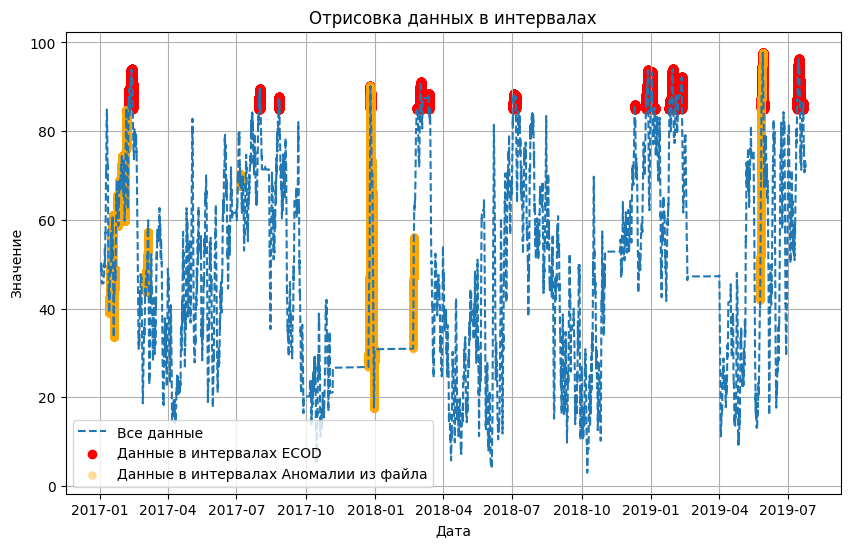

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


df['timestamp'] = pd.to_datetime(df['timestamp'])
# Определите интервалы
intervals = intervals
intervals_an = date_tuples

# Фильтруем DataFrame, чтобы получить только строки, которые находятся в интервалах
filtered_df = pd.DataFrame()
filtered_df_an = pd.DataFrame()

for interval in intervals:
    start_date, end_date = interval
    mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
    interval_df = df.loc[mask]
    filtered_df = pd.concat([filtered_df, interval_df])
print(filtered_df)
for interval in intervals_an:
    start_date, end_date = interval
    mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
    interval_df = df.loc[mask]
    filtered_df_an = pd.concat([filtered_df_an, interval_df])
print(filtered_df_an)

# Отрисовываем полученные данные
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['target_mean'], label='Все данные', linestyle='--')
plt.scatter(filtered_df['timestamp'], filtered_df['target_mean'], color='red', label='Данные в интервалах ECOD')
plt.scatter(filtered_df_an['timestamp'], filtered_df_an['target_mean'], color='orange', label='Данные в интервалах Аномалии из файла', alpha = 0.4,linewidths=0.1)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.title('Отрисовка данных в интервалах')
plt.grid(True)
plt.show()

In [ ]:
import json
from datetime import datetime


# Преобразование интервалов в список словарей
interval_dicts = []

for start, end in intervals:
    interval_dict = {
        "start": str(start),
        "end": str(end),
        "duration_hours": (end - start).total_seconds() / 3600
    }
    interval_dicts.append(interval_dict)

# Преобразование в JSON
json_data = json.dumps(interval_dicts, indent=4)

# Сохранение JSON в файл
with open("intervals_ECOD.json", "w") as json_file:
    json_file.write(json_data)